Starting Q-learning training with enhanced peak shaving focus...
Episode 10000/150000, Epsilon: 0.6413, Total Reward: -799.50
Episode 20000/150000, Epsilon: 0.4125, Total Reward: -588.50
Episode 30000/150000, Epsilon: 0.2667, Total Reward: -351.50
Episode 40000/150000, Epsilon: 0.1737, Total Reward: -126.50
Episode 50000/150000, Epsilon: 0.1143, Total Reward: 41.50
Episode 60000/150000, Epsilon: 0.0765, Total Reward: 92.00
Episode 70000/150000, Epsilon: 0.0524, Total Reward: 89.50
Episode 80000/150000, Epsilon: 0.0371, Total Reward: -72.00
Episode 90000/150000, Epsilon: 0.0272, Total Reward: 102.00
Episode 100000/150000, Epsilon: 0.0210, Total Reward: 97.00
Episode 110000/150000, Epsilon: 0.0170, Total Reward: 102.00
Episode 120000/150000, Epsilon: 0.0145, Total Reward: 94.50
Episode 130000/150000, Epsilon: 0.0129, Total Reward: 89.50
Episode 140000/150000, Epsilon: 0.0118, Total Reward: 29.00
Episode 150000/150000, Epsilon: 0.0112, Total Reward: 99.50
Q-learning training complete.

Si

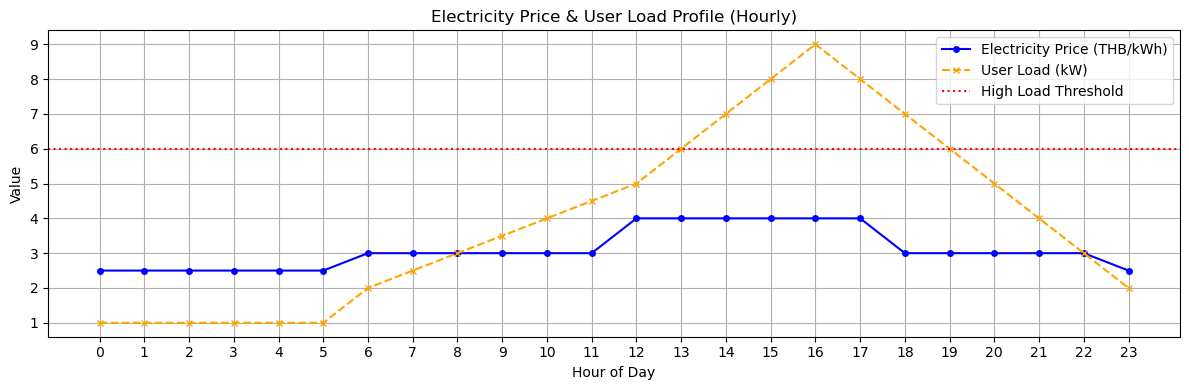

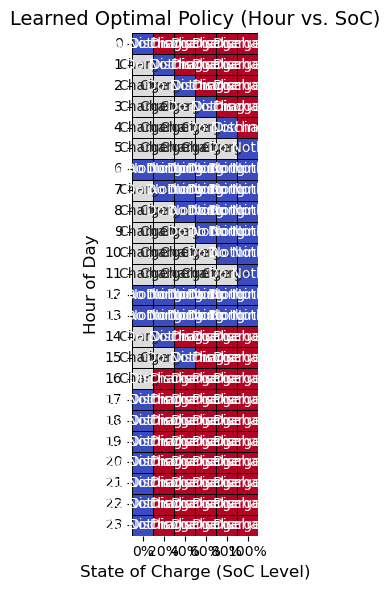

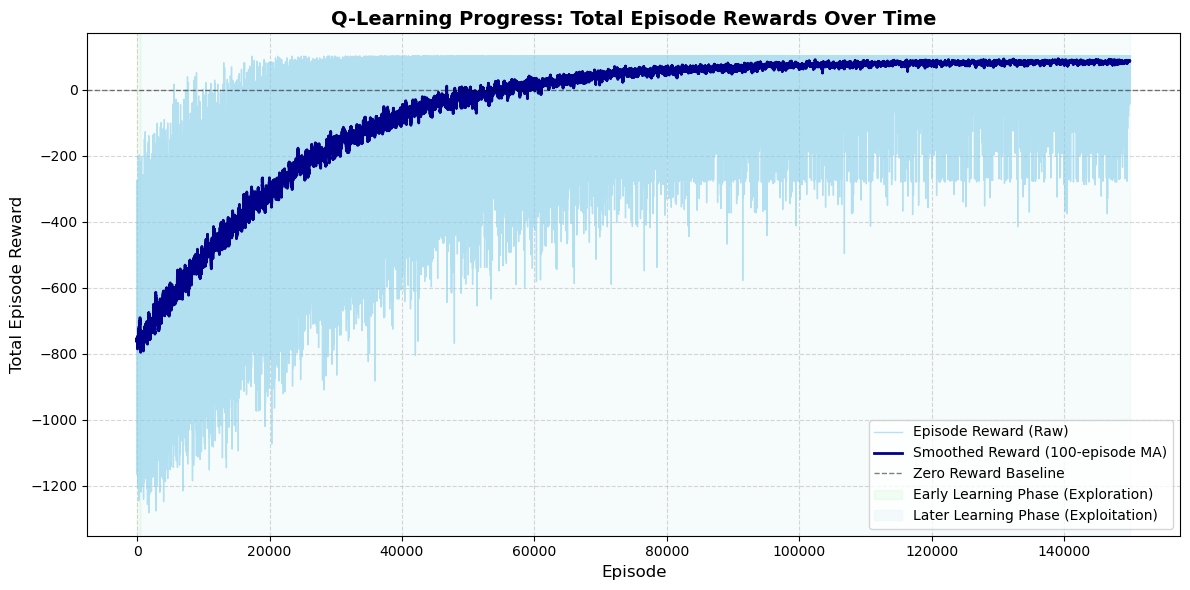

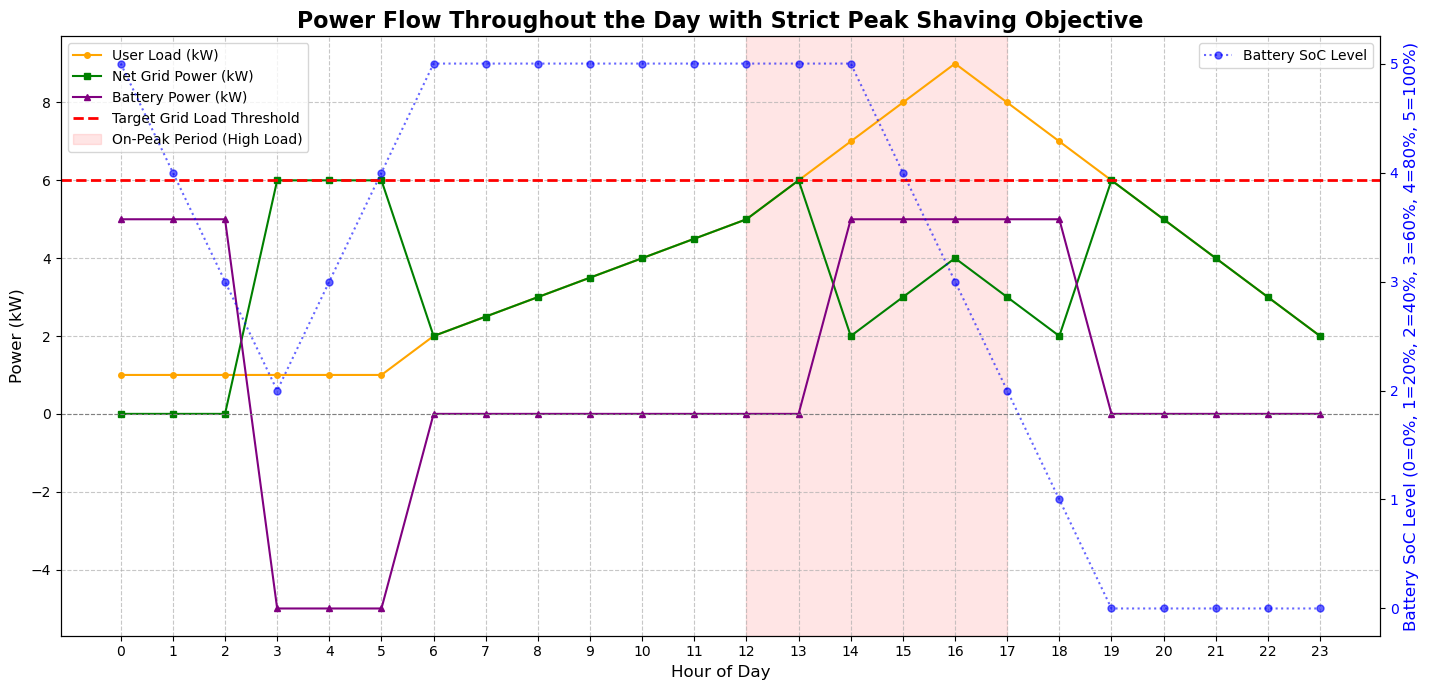


=== Optimal Policy (Hour x SoC) - With Enhanced Peak Shaving Focus ===
Hour | 0% (Empty)| 20%       | 40%       | 60%       | 80%       | 100% (Full)
-----|-----------|-----------|-----------|-----------|-----------|------------
   0 | Do Nothing| Discharge | Discharge | Discharge | Discharge | Discharge 
   1 | Charge    | Do Nothing| Discharge | Discharge | Discharge | Discharge 
   2 | Charge    | Charge    | Do Nothing| Discharge | Discharge | Discharge 
   3 | Charge    | Charge    | Charge    | Do Nothing| Discharge | Discharge 
   4 | Charge    | Charge    | Charge    | Charge    | Do Nothing| Discharge 
   5 | Charge    | Charge    | Charge    | Charge    | Charge    | Do Nothing
   6 | Do Nothing| Do Nothing| Do Nothing| Do Nothing| Do Nothing| Do Nothing
   7 | Charge    | Do Nothing| Do Nothing| Do Nothing| Do Nothing| Do Nothing
   8 | Charge    | Charge    | Do Nothing| Do Nothing| Do Nothing| Do Nothing
   9 | Charge    | Charge    | Charge    | Do Nothing| Do Nothing| D

In [2]:
#Gemini 
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

# === BESS Settings === #
HOURS = 24
# MODIFIED: 6 SoC levels (0%, 20%, 40%, 60%, 80%, 100%)
SOC_LEVELS = 6
ACTIONS = ['Do Nothing', 'Charge', 'Discharge']
NUM_ACTIONS = len(ACTIONS)

# === Electricity price per hour (THB/kWh) - TOU Tariff in Thailand === #
electricity_prices = [
    2.50, 2.50, 2.50, 2.50, 2.50, 2.50,  # Off-Peak
    3.00, 3.00, 3.00, 3.00, 3.00, 3.00,  # Mid-Peak
    4.00, 4.00, 4.00, 4.00, 4.00, 4.00,  # On-Peak - Highest prices
    3.00, 3.00, 3.00, 3.00, 3.00, 2.50   # Evening tapering
]

# === Load profile (in kW) - User demand at each hour === #
load_profile = [
    1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
    2.0, 2.5, 3.0, 3.5, 4.0, 4.5,
    5.0, 6.0, 7.0, 8.0, 9.0, 8.0,  # High loads around 14:00-17:00
    7.0, 6.0, 5.0, 4.0, 3.0, 2.0
]

HIGH_LOAD_THRESHOLD = 6.0  # kW - Grid power should ideally stay below this

# === Battery Power Conversion (Simplified for this model) === #
# Assuming BATTERY_POWER_CHARGE/DISCHARGE represent the power for one SoC level change
BATTERY_POWER_CHARGE = 5.0  # kW drawn by battery from grid when charging by one SoC level
BATTERY_POWER_DISCHARGE = 5.0 # kW supplied by battery to load when discharging by one SoC level

# === Hyperparameters === #
EPISODES = 100000
ALPHA = 0.1
GAMMA = 0.98
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY_RATE = 0.000045

# === Initialize Q-table === #
Q = np.zeros((HOURS, SOC_LEVELS, NUM_ACTIONS))

# === Helper Functions === #

def choose_action(hour, soc, current_epsilon):
    if random.uniform(0, 1) < current_epsilon:
        return random.choice([0, 1, 2])
    else:
        return np.argmax(Q[hour, soc])

def get_reward(action, hour, soc):
    price = electricity_prices[hour]
    load = load_profile[hour]
    
    base_reward = 0.0

    if action == 0:  # Do Nothing
        if load > HIGH_LOAD_THRESHOLD and soc > 0:
            base_reward = -20.0
        else:
            base_reward = 0
    
    elif action == 1:  # Charge
        if soc < SOC_LEVELS - 1: # Can only charge if not full
            base_reward = -price
            
            if load > HIGH_LOAD_THRESHOLD or price == 4.00: 
                base_reward -= 100.0 
            
        else: # Penalty for trying to charge a full battery (invalid action)
            base_reward = -10.0

    elif action == 2:  # Discharge
        if soc > 0: # Can only discharge if not empty
            base_reward = price
            
            if load > HIGH_LOAD_THRESHOLD:
                base_reward += 15.0
            if price == 4.00:
                base_reward += 2.0
        else: # Penalty for trying to discharge an empty battery (invalid action)
            base_reward = -10.0
            
    return base_reward

# Track total reward per episode
episode_rewards = []

# === Q-learning Training Loop === #
print("Starting Q-learning training with enhanced peak shaving focus...")
for episode in range(EPISODES):
    current_epsilon = EPSILON_END + (EPSILON_START - EPSILON_END) * np.exp(-EPSILON_DECAY_RATE * episode)
    
    total_reward = 0
    hour = 0
    soc = random.randint(0, SOC_LEVELS - 1) # Start each episode with a random SoC

    while hour < HOURS:
        action = choose_action(hour, soc, current_epsilon)
        base_reward_from_func = get_reward(action, hour, soc)
        
        # Calculate current grid power to apply direct penalty
        current_load = load_profile[hour]
        instantaneous_grid_power = 0.0
        
        if action == 1 and soc < SOC_LEVELS - 1: # Charging
            instantaneous_grid_power = current_load + BATTERY_POWER_CHARGE
        elif action == 2 and soc > 0: # Discharging
            instantaneous_grid_power = max(0, current_load - BATTERY_POWER_DISCHARGE)
        else: # Do Nothing or invalid action
            instantaneous_grid_power = current_load

        # Apply a VERY STRONG penalty if the grid power exceeds the threshold
        additional_penalty = 0.0
        if instantaneous_grid_power > HIGH_LOAD_THRESHOLD:
            base_threshold_penalty = -50.0
            
            if hour == 16: 
                additional_penalty = base_threshold_penalty * 5.0
            elif hour == 17: 
                additional_penalty = base_threshold_penalty * 2.0
            else: 
                additional_penalty = base_threshold_penalty
        
        reward = base_reward_from_func + additional_penalty

        total_reward += reward

        next_hour = hour + 1
        next_soc = soc

        if action == 1 and soc < SOC_LEVELS - 1: # If charging and not already full
            next_soc += 1
        elif action == 2 and soc > 0: # If discharging and not already empty
            next_soc -= 1
        # If action is "Do Nothing", or invalid charge/discharging, SoC remains unchanged


        # Q-learning update (Bellman equation)
        if next_hour < HOURS:
            best_future_q = np.max(Q[next_hour, next_soc])
        else:
            best_future_q = 0

        td_target = reward + GAMMA * best_future_q
        td_error = td_target - Q[hour][soc][action]
        Q[hour][soc][action] += ALPHA * td_error

        hour = next_hour
        soc = next_soc
    
    episode_rewards.append(total_reward)

    if (episode + 1) % 10000 == 0:
        print(f"Episode {episode + 1}/{EPISODES}, Epsilon: {current_epsilon:.4f}, Total Reward: {total_reward:.2f}")

print("Q-learning training complete.")

# === Extract Policy === #
policy = np.full((HOURS, SOC_LEVELS), '', dtype=object)
action_colors = np.zeros((HOURS, SOC_LEVELS))
ACTION_COLORS = {'Do Nothing': 0, 'Charge': 1, 'Discharge': 2}

for h in range(HOURS):
    for s in range(SOC_LEVELS):
        best_action = np.argmax(Q[h][s])
        policy[h][s] = ACTIONS[best_action]
        action_colors[h][s] = ACTION_COLORS[ACTIONS[best_action]]

# === Simulation for Visualization using the Learned Policy === #
sim_soc_levels = []
sim_battery_power = []
sim_grid_power = []

current_soc = SOC_LEVELS - 1 # Start at "Full" for the simulation visual
print(f"\nSimulating one day using the learned policy, starting SoC: {current_soc} (100% equivalent)")

for h in range(HOURS):
    sim_soc_levels.append(current_soc)
    
    # Get the action from the learned policy
    action_index = np.argmax(Q[h, current_soc])
    action = ACTIONS[action_index]
    
    load = load_profile[h]
    battery_power_at_hour = 0.0
    grid_power_at_hour = 0.0

    if action == 'Charge':
        if current_soc < SOC_LEVELS - 1:
            current_soc += 1
            battery_power_at_hour = -BATTERY_POWER_CHARGE
            grid_power_at_hour = load + BATTERY_POWER_CHARGE
        else:
            grid_power_at_hour = load
    elif action == 'Discharge':
        if current_soc > 0:
            current_soc -= 1
            battery_power_at_hour = BATTERY_POWER_DISCHARGE
            grid_power_at_hour = max(0, load - BATTERY_POWER_DISCHARGE)
        else:
            grid_power_at_hour = load
    else: # Do Nothing
        grid_power_at_hour = load

    sim_battery_power.append(battery_power_at_hour)
    sim_grid_power.append(grid_power_at_hour)

# === Visualization Section === #

# 1. Plot Prices and Load Profile
plt.figure(figsize=(12, 4))
hours_list = list(range(HOURS))
plt.plot(hours_list, electricity_prices, label='Electricity Price (THB/kWh)', color='blue', marker='o', markersize=4)
plt.plot(hours_list, load_profile, label='User Load (kW)', color='orange', linestyle='--', marker='x', markersize=4)
plt.axhline(HIGH_LOAD_THRESHOLD, color='red', linestyle=':', label='High Load Threshold')
plt.title('Electricity Price & User Load Profile (Hourly)')
plt.xlabel('Hour of Day')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.xticks(hours_list)
plt.tight_layout()
plt.show()

# 2. Heatmap of Policy
plt.figure(figsize=(8, 20))
sns.heatmap(action_colors, annot=policy, cmap="coolwarm", cbar=False, square=True, fmt='',
            linewidths=.5, linecolor='black')
plt.title("Learned Optimal Policy (Hour vs. SoC)", fontsize=14)
plt.xlabel("State of Charge (SoC Level)", fontsize=12)
plt.ylabel("Hour of Day", fontsize=12)
plt.yticks(ticks=np.arange(HOURS)+0.5, labels=hours_list, rotation=0)
# MODIFIED: Update SoC labels for 6 levels
plt.xticks(ticks=np.arange(SOC_LEVELS)+0.5, labels=['0%', '20%', '40%', '60%', '80%', '100%'])
plt.tight_layout()
plt.show()

# 3. Episode Rewards Over Time
plt.figure(figsize=(12, 6))
plt.plot(episode_rewards, label='Episode Reward (Raw)', color='skyblue', alpha=0.6, linewidth=1)
window = 100
if len(episode_rewards) >= window:
    smoothed = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
    plt.plot(smoothed, label=f'Smoothed Reward ({window}-episode MA)', color='darkblue', linewidth=2)
else:
    print(f"Not enough episodes ({len(episode_rewards)}) to create smoothed reward plot with window {window}.")
plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Zero Reward Baseline')
if len(smoothed) > 200:
    plt.axvspan(0, 500, color='lightgreen', alpha=0.1, label='Early Learning Phase (Exploration)')
    plt.axvspan(500, EPISODES, color='lightblue', alpha=0.1, label='Later Learning Phase (Exploitation)')
plt.title('Q-Learning Progress: Total Episode Rewards Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Total Episode Reward', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend(loc='lower right', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# 4. New Visualization: Battery Power Support and Grid Power (Focus on Peak Shaving)
plt.figure(figsize=(14, 7))
plt.plot(hours_list, load_profile, label='User Load (kW)', color='orange', linestyle='-', marker='o', markersize=4)
plt.plot(hours_list, sim_grid_power, label='Net Grid Power (kW)', color='green', linestyle='-', marker='s', markersize=4)
plt.plot(hours_list, sim_battery_power, label='Battery Power (kW)', color='purple', linestyle='-', marker='^', markersize=4)

plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)
plt.axhline(HIGH_LOAD_THRESHOLD, color='red', linestyle='--', linewidth=2, label='Target Grid Load Threshold')

plt.axvspan(12, 17, color='red', alpha=0.1, label='On-Peak Period (High Load)')

plt.title('Power Flow Throughout the Day with Strict Peak Shaving Objective', fontsize=16, fontweight='bold')
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Power (kW)', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend(loc='upper left', fontsize=10)
plt.xticks(hours_list)
plt.tight_layout()

# Adding secondary y-axis for SoC level
ax2 = plt.gca().twinx()
ax2.plot(hours_list, sim_soc_levels, label='Battery SoC Level', color='blue', linestyle=':', marker='o', alpha=0.6, markersize=5)
# MODIFIED: Update SoC label for 6 levels
ax2.set_ylabel('Battery SoC Level (0=0%, 1=20%, 2=40%, 3=60%, 4=80%, 5=100%)', color='blue', fontsize=12)
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_yticks(np.arange(SOC_LEVELS))
ax2.legend(loc='upper right', fontsize=10)

plt.show()

# === Print Final Policy === #
print("\n=== Optimal Policy (Hour x SoC) - With Enhanced Peak Shaving Focus ===")
# MODIFIED: Update print headers for 6 levels
print("Hour | 0% (Empty)| 20%       | 40%       | 60%       | 80%       | 100% (Full)")
print("-----|-----------|-----------|-----------|-----------|-----------|------------")
for h in range(HOURS):
    # MODIFIED: Print all 6 SoC levels
    print(f"{h:4d} | {policy[h, 0]:10s}| {policy[h, 1]:10s}| {policy[h, 2]:10s}| {policy[h, 3]:10s}| {policy[h, 4]:10s}| {policy[h, 5]:10s}")

print("\n--- Simulation Summary ---")
print("This simulation incorporates further refined hyperparameters and reward structures,")
print("aiming to optimize peak shaving by encouraging proactive battery management and strongly penalizing undesired actions during peak hours.")
print("\nBattery Power line indicates:")
print("  - Positive values: Battery is discharging (supporting the load, reducing grid demand).")
print("  - Negative values: Battery is charging (drawing power from the grid).")
print("The 'Net Grid Power' line shows the actual power drawn from the grid after battery interaction.")

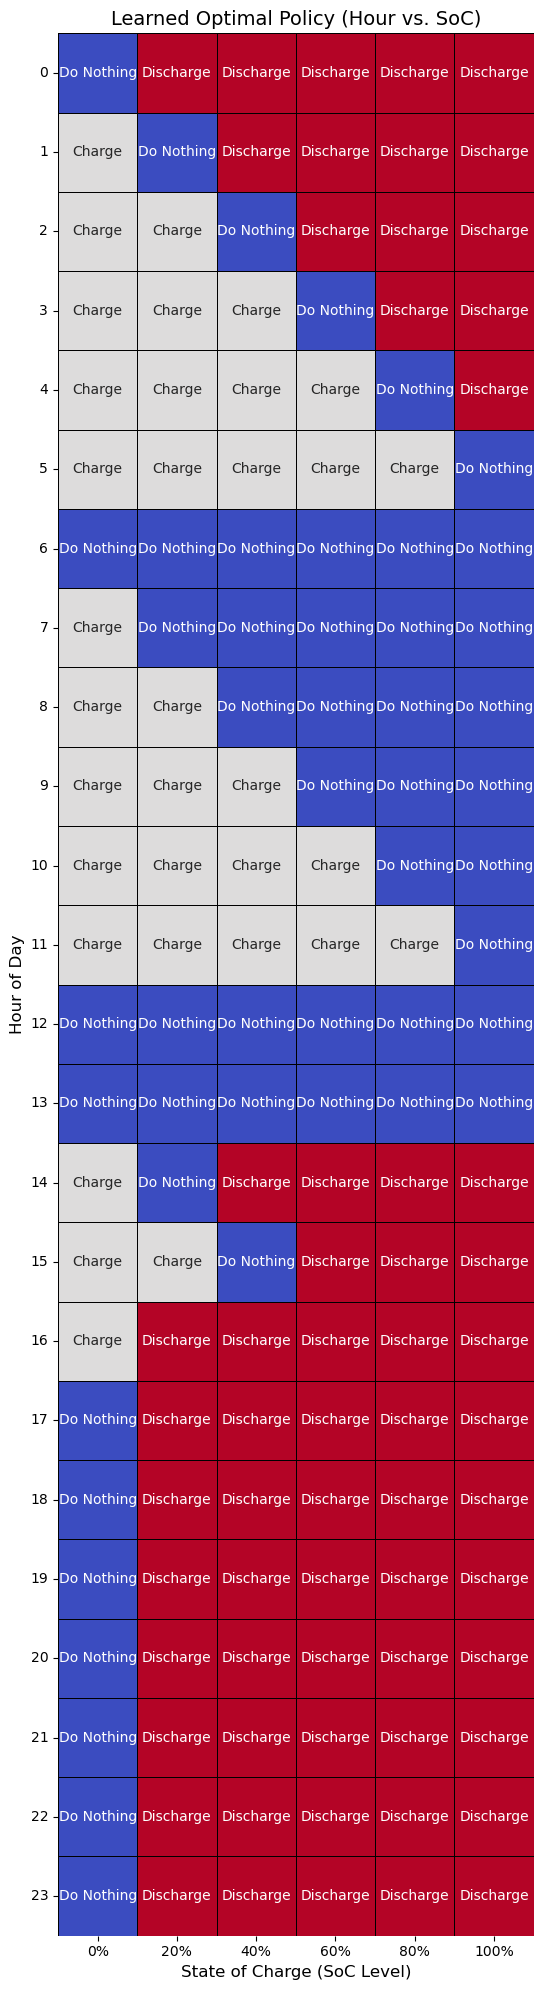

In [3]:
# 2. Heatmap of Policy
plt.figure(figsize=(8, 20))
sns.heatmap(action_colors, annot=policy, cmap="coolwarm", cbar=False, square=True, fmt='',
            linewidths=.5, linecolor='black')
plt.title("Learned Optimal Policy (Hour vs. SoC)", fontsize=14)
plt.xlabel("State of Charge (SoC Level)", fontsize=12)
plt.ylabel("Hour of Day", fontsize=12)
plt.yticks(ticks=np.arange(HOURS)+0.5, labels=hours_list, rotation=0)
# MODIFIED: Update SoC labels for 6 levels
plt.xticks(ticks=np.arange(SOC_LEVELS)+0.5, labels=['0%', '20%', '40%', '60%', '80%', '100%'])
plt.tight_layout()
plt.show()
